In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")

# Ejercicio de clasificaci√≥n - Problema desbalanceado
**Facundo A. Lucianna - Inteligencia Artificial - CEIA - FIUBA**

Ahora vamos a trabajar con un problema que se caracteriza por tener un gran desbalance de clases. Este tipo de situaci√≥n es muy com√∫n en la pr√°ctica y requiere aplicar t√©cnicas espec√≠ficas para obtener buenos resultados. Existen m√∫ltiples estrategias para abordar estos casos, las cuales estudiar√°n en asignaturas posteriores. Entre ellas podemos mencionar:

- Uso de pesos en la funci√≥n de p√©rdida (como `class_weight='balanced'`)
- Submuestreo de la clase mayoritaria (**undersampling**)
- Sobremuestreo de la clase minoritaria (**oversampling**)
- T√©cnicas de generaci√≥n sint√©tica de datos como **SMOTE**
- Algoritmos espec√≠ficos para clases desbalanceadas (por ejemplo, `BalancedRandomForestClassifier`)

En este caso, vamos a usar un modelo de regresi√≥n log√≠stica, el cual ser√° entrenado indic√°ndole que se le d√© mayor importancia a la clase minoritaria (que en general es la clase positiva, la que representa el evento poco frecuente).

Esto se logra ajustando la funci√≥n de p√©rdida (la log-verosimilitud negativa) mediante un peso proporcional al desbalance de clases. En **scikit-learn**, este ajuste se realiza con el argumento `class_weight`, y la forma autom√°tica que aplicaremos es:

```python
class_weight='balanced'
```

**Entonces, ¬øqu√© hace `'balanced'`?**

**Scikit-learn** calcula autom√°ticamente los pesos para cada clase seg√∫n la f√≥rmula:

```python
peso_clase_i = n_muestras_totales / (n_clases * cantidad_de_muestras_de_clase_i)
```

Esto significa que:

- Si una clase aparece poco, su peso es mayor ‚Üí el modelo *‚Äúescucha m√°s fuerte‚Äù* a esas muestras.
- Si una clase aparece mucho, su peso es menor ‚Üí su influencia se reduce, evitando que domine el aprendizaje.
- Al usarse un peso inversamente proporcional a la frecuencia de la clase, se compensa el desbalance, haciendo que el impacto total de cada clase en el entrenamiento sea m√°s equilibrado.

**¬øQu√© logra este enfoque?**

Esto hace que el modelo:

- El modelo se penaliza m√°s por equivocarse en la clase minoritaria.
- Aprende a distinguir mejor ambas clases.
- Generaliza mejor en datasets desbalanceados, evitando predecir siempre la clase mayoritaria.

---
### Descripci√≥n del problema

Vamos a estudiar un dataset que contiene informaci√≥n sobre el incumplimiento de pago por parte de clientes de una compa√±√≠a de tarjetas de cr√©dito.

De cada cliente se tiene:

- El saldo que se le factur√≥ en la tarjeta (`balance`)
- Si es estudiante universitario o no (`student`)
- Su sueldo anual (`income`)
- Y si incumpli√≥ el pago (`default`), que ser√° nuestra variable objetivo.

En este caso, la clase de inter√©s (la clase positiva) es la de clientes que incumplen el pago, que representa una minor√≠a dentro del conjunto de datos. Esto hace que el problema sea naturalmente desbalanceado, y por eso es un excelente caso para aplicar lo que aprendimos sobre el ajuste de pesos en modelos de clasificaci√≥n.

In [2]:
default_df = pd.read_csv("./datasets/Default.csv")

### Exploraci√≥n de los datos

Veamos un poco nuestros datos

In [3]:
default_df.head()

default student      balance        income
0      No      No   729.526495  44361.625074
1      No     Yes   817.180407  12106.134700
2      No      No  1073.549164  31767.138947
3      No      No   529.250605  35704.493935
4      No      No   785.655883  38463.495879

In [4]:
default_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


Vamos a convertir las columnas `default` y `student` en columnas num√©ricas y otras con nombres m√°s legibles. Esto va a ser √∫til tanto para visualizaciones como para el modelo de regresi√≥n log√≠stica, que no permite variables categ√≥ricas directamente (a menos que se conviertan con one-hot encoding, pero en este caso usaremos la versi√≥n binaria).

In [5]:
default_df["Incumplimiento"] = default_df["default"].apply(lambda x: "Si" if x == "Yes" else "No")
default_df["Estudiante"] = default_df["student"].apply(lambda x: "Si" if x == "Yes" else "No")

default_df["default"] = default_df["default"].apply(lambda x: 1 if x == "Yes" else 0)
default_df["student"] = default_df["student"].apply(lambda x: 1 if x == "Yes" else 0)

Tenemos 2 **columnas num√©ricas**, 1 **categ√≥rica**, y un **label categ√≥rico**. No hay valores faltantes. Veamos una breve descripci√≥n de los atributos y el label:

- `default`: Es la variable objetivo (label). Si es 1, significa que la persona incumpli√≥ el pago de la tarjeta.
- `student`: Variable categ√≥rica que indica si la persona es estudiante. Vale 1 si es estudiante y 0 si no lo es.
- `balance`: Monto del resumen de la tarjeta de cr√©dito a pagar. 
- `income`: Ingreso anual de la persona titular de la tarjeta.

Veamos el balance de clases:

In [6]:
default_df.Incumplimiento.value_counts()

Incumplimiento
No    9667
Si     333
Name: count, dtype: int64

Observamos una gran desproporci√≥n de clases: solo el **3.3% de las observaciones** corresponde a personas que incumplieron. Este n√∫mero tiene sentido; en general, la mayor√≠a de las personas pagan sus deudas. Si este porcentaje fuera m√°s alto, significar√≠a que ofrecer tarjetas de cr√©dito ser√≠a un muy mal negocio.

Podemos ajustar un poco el desbalance, ya que existen casos donde el `balance` de la tarjeta es cero, y todos esos est√°n pagados:

In [7]:
default_df[default_df["balance"] == 0].Incumplimiento.value_counts()

Incumplimiento
No    499
Name: count, dtype: int64

Eliminamos esos casos:

In [8]:
default_df = default_df[default_df["balance"] != 0]
default_df.Incumplimiento.value_counts()

Incumplimiento
No    9168
Si     333
Name: count, dtype: int64

Ahora la proporci√≥n mejora **ligeramente a un 3.5%**, lo que sigue siendo muy desbalanceado, pero es un poco mejor.

#### Visualizaci√≥n de los datos


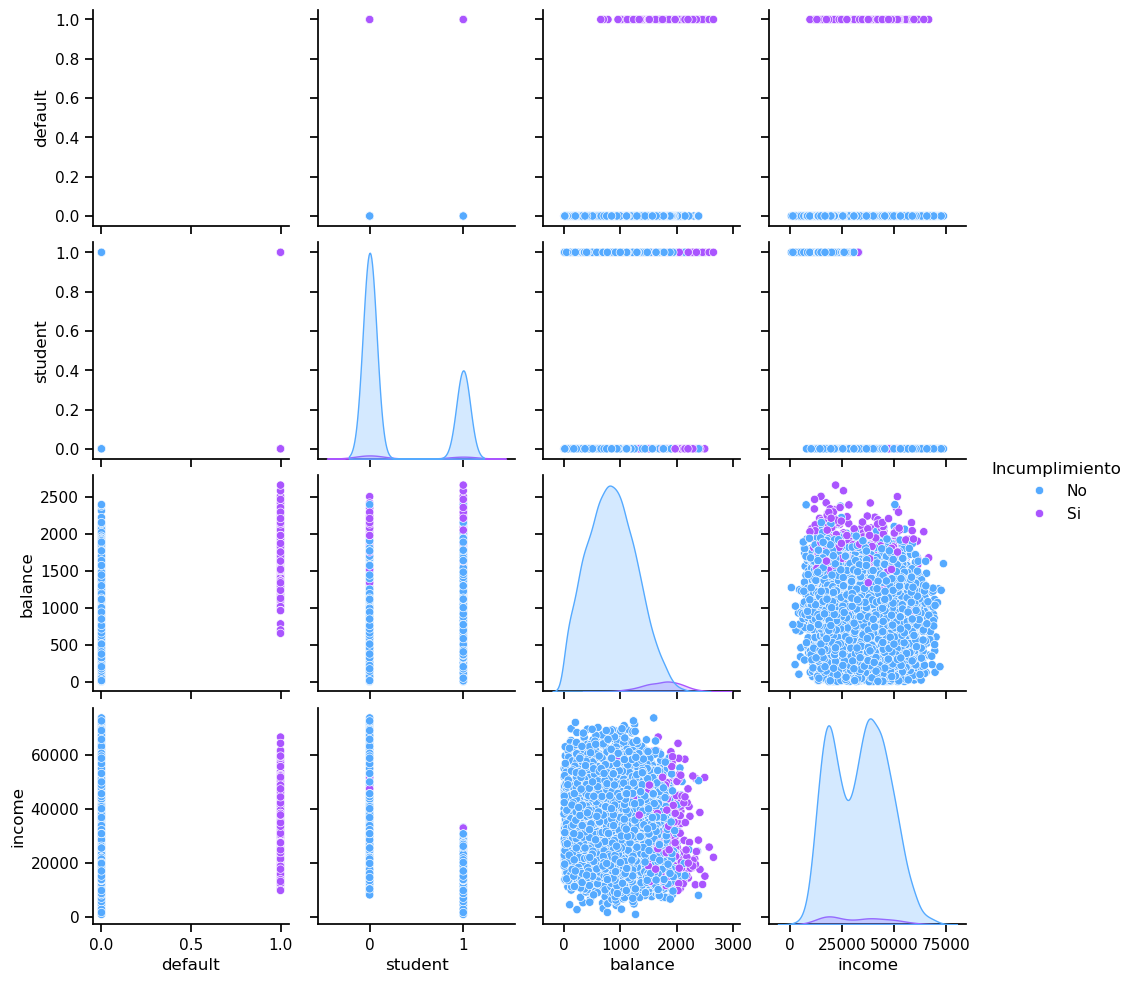

In [9]:
sns.pairplot(data=default_df, diag_kind="kde", hue="Incumplimiento", palette="cool");

Veamos un gr√°fico de dispersi√≥n m√°s detallado, codificando `student` con la forma del punto, y `default` con el color:

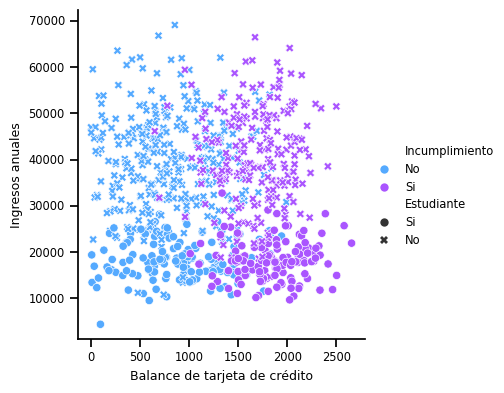

In [10]:
# Submuestreamos para facilitar la visualizaci√≥n
df_sample_no_default = default_df[default_df["default"] == 0].copy()
df_sample_no_default = df_sample_no_default.sample(frac=0.05)
df_sample_default = default_df[default_df["default"] == 1].copy()

sns.set_context("notebook", font_scale=0.75)
g = sns.relplot(data=pd.concat([df_sample_no_default, df_sample_default]), x="balance", y="income", 
                hue="Incumplimiento", style="Estudiante", kind="scatter", legend=True, palette="cool",
                height=4)
plt.xlabel("Balance de tarjeta de cr√©dito")
plt.ylabel("Ingresos anuales");

Observaciones del gr√°fico:
- Los estudiantes tienden a tener ingresos menores que los no estudiantes.
- La mayor√≠a de los incumplimientos ocurren cuando el balance de la tarjeta es alto.
- A simple vista, el ingreso no parece ser un factor determinante en el incumplimiento.
- En los estudiantes, los incumplimientos tienden a aparecer en balances m√°s altos comparado con los no estudiantes.

Veamos ahora diagramas de caja:

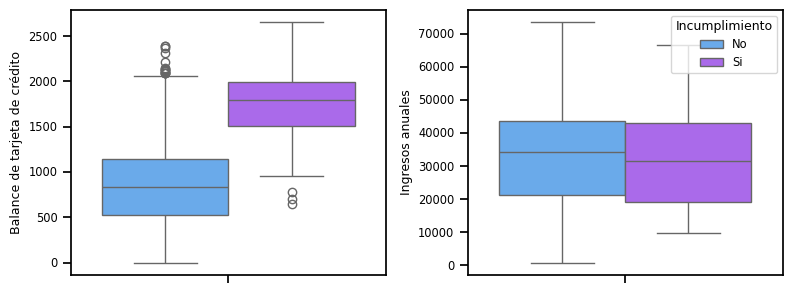

In [11]:
f, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.boxplot(data=default_df, y="balance", hue="Incumplimiento", ax=ax[0], 
            palette="cool", legend=False)
sns.boxplot(data=default_df, y="income", hue="Incumplimiento", ax=ax[1], 
            palette="cool", legend=True)
ax[0].set_ylabel("Balance de tarjeta de cr√©dito")
ax[1].set_ylabel("Ingresos anuales")
plt.tight_layout();

Observaciones:
- Las personas que incumplen tienen balances notablemente m√°s altos.
- Para los ingresos, aunque hay mucho solapamiento, la media del grupo que incumple parece m√°s baja que la del grupo que paga.

Ahora analicemos el efecto de ser estudiante:

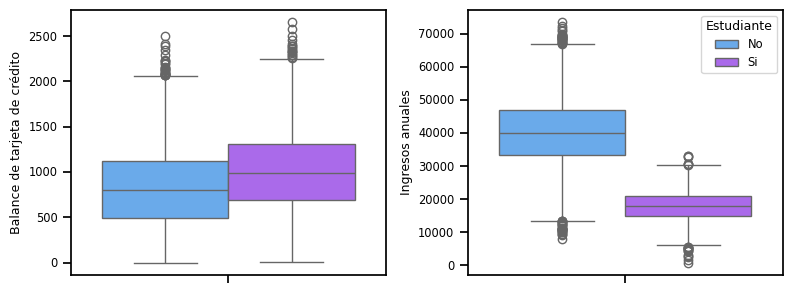

In [12]:
f, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.boxplot(data=default_df, y="balance", hue="Estudiante", ax=ax[0], 
            palette="cool", legend=False)
sns.boxplot(data=default_df, y="income", hue="Estudiante", ax=ax[1], 
            palette="cool", legend=True)
ax[0].set_ylabel("Balance de tarjeta de cr√©dito")
ax[1].set_ylabel("Ingresos anuales")
plt.tight_layout();

Observaciones:
- Los estudiantes tienen ingresos claramente m√°s bajos que los no estudiantes.
- Los balances de tarjeta de cr√©dito tienden a ser m√°s altos en estudiantes.

Analicemos la tasa de incumplimiento por nivel de balance y condici√≥n de estudiante:

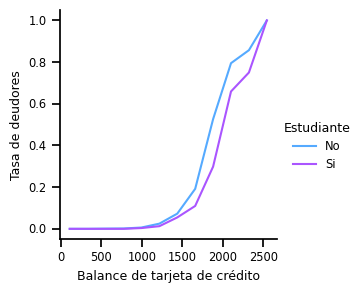

In [13]:
# Segmentamos el balance en bins
default_df["balance_bin"] = pd.cut(default_df['balance'], 12).apply(lambda x: x.mid)

df_grouped = default_df.groupby(["balance_bin", "student"], as_index=False, observed=True).agg({
    "default": ["sum", "count"] 
})
df_grouped.columns = ["balance", "Estudiante", "sum", "count"]
df_grouped["default_rate"] = df_grouped["sum"] / df_grouped["count"]

df_grouped["Estudiante"] = df_grouped["Estudiante"].apply(lambda x: "Si" if x == 1 else "No")

g = sns.relplot(data=df_grouped, x="balance", y="default_rate", hue="Estudiante", 
                kind="line", legend='auto', palette='cool', height=3)
plt.xlabel("Balance de tarjeta de cr√©dito")
plt.ylabel("Tasa de deudores");

¬øQu√© observamos?
- Dado un mismo nivel de balance, los estudiantes tienen una menor tasa de incumplimiento que los no estudiantes.

---
### Primer modelo de regresi√≥n log√≠stica usando `balance`

Podemos ver que la variable balance de tarjeta de cr√©dito es la mejor candidata para clasificar si una persona va a pagar o no. Por lo tanto, armemos un modelo de regresi√≥n log√≠stica simple utilizando √∫nicamente `balance`.

In [14]:
X = default_df[["balance"]]
y = default_df["default"]

Para no perder el delicado equilibrio entre clases, usamos el argumento `stratify` en la funci√≥n `train_test_split`, as√≠ nos aseguramos de que ambos conjuntos (entrenamiento y testeo) mantengan la misma proporci√≥n de clases:

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, 
                                                    stratify=y)

Ya con los datos de entrenamiento, entrenamos un modelo de regresi√≥n log√≠stica de [sckit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), recordando que vamos a usar `class_weight="balanced"` para indicarle al modelo que compense autom√°ticamente la diferencia entre clases durante el ajuste (esto se hace ajustando los pesos en la funci√≥n de p√©rdida).

> üß† **Nota**: Aunque en este caso hay solo un atributo, vamos a usar un pipeline con preprocesamiento para aplicar el escalamiento. Esto es una buena pr√°ctica general para evitar problemas num√©ricos y mantener el flujo organizado.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocesamiento para la columna num√©rica
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ["balance"])
    ]
)

# Pipeline: preprocesamiento + modelo
log_1_attr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LogisticRegression(random_state=0, class_weight="balanced"))
])

In [17]:
log_1_attr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['balance'])])),
                ('regressor',
                 LogisticRegression(class_weight='balanced', random_state=0))])

M√°s adelante vamos a evaluar este modelo. Por ahora, vamos a crear un par de modelos m√°s.

----

### Modelo de regresi√≥n log√≠stica usando solamente `student`

Ahora apliquemos otro modelo de regresi√≥n log√≠stica, pero utilizando solo la variable categ√≥rica `student`, que ya est√° codificada como binaria. Esta variable parec√≠a un buen candidato para predecir el incumplimiento, dado que en las visualizaciones vimos que los estudiantes, a igualdad de balance, ten√≠an tasas de incumplimiento m√°s bajas que los no estudiantes.

In [18]:
Xstudent = default_df[["student"]]
ystudent = default_df["default"]

(X_train_student, 
 X_test_student, 
 y_train_student, 
 y_test_student) = train_test_split(Xstudent, ystudent, test_size=0.25, random_state = 0, stratify=y)

# No es necesario escalar esta variable binaria
classifier_student = LogisticRegression(random_state = 0, class_weight="balanced")
classifier_student.fit(X_train_student, y_train_student)

LogisticRegression(class_weight='balanced', random_state=0)

Como `student` es una variable booleana, podemos ver la salida probabil√≠stica del modelo en ambos casos

In [19]:
student_input = pd.DataFrame({"student": [1]})
student_out = classifier_student.predict_proba(student_input)[0, -1]

no_student_input = pd.DataFrame({"student": [0]})
no_student_out = classifier_student.predict_proba(no_student_input)[0, -1]

print(f"La probabilidad de incumplimiento si es estudiante: {student_out}")
print(f"La probabilidad de incumplimiento si NO es estudiante: {no_student_out}")

La probabilidad de incumplimiento si es estudiante: 0.5645924181685548
La probabilidad de incumplimiento si NO es estudiante: 0.46567368825289024


**¬øQu√© est√° pasando?**

Vemos que si la persona es estudiante, el modelo le asigna mayor probabilidad de no pagar... ¬°pero hab√≠amos observado lo contrario en el an√°lisis exploratorio!

Aunque un estudiante individual, con un saldo de tarjeta determinado, tiende a tener una menor probabilidad de incumplimiento que un no estudiante con el mismo balance, el hecho de que los estudiantes tienden a tener balances m√°s altos en general, implica que en t√©rminos globales, los estudiantes incumplen m√°s que los no estudiantes.

> üìå En otras palabras:
> - Dado un mismo balance ‚Üí el estudiante es menos riesgoso.
> - Sin considerar balance ‚Üí el estudiante es m√°s riesgoso.

Esto es una distinci√≥n muy importante para una compa√±√≠a de tarjetas de cr√©dito que intenta decidir a qui√©n ofrecerle cr√©dito. Un estudiante es m√°s riesgoso si no se tiene en cuenta el balance, pero menos riesgoso si se controla por ese factor.

Este ejemplo ilustra un fen√≥meno conocido como factor de **confusi√≥n** o **confounder**.

> üß† **¬øQu√© es un factor de confusi√≥n?**
>
> Un factor de confusi√≥n es una variable que afecta simult√°neamente a la variable independiente y a la dependiente, generando una relaci√≥n espuria (aparentemente directa) entre ellas. Es decir, se observa una asociaci√≥n que en realidad es causada por una tercera variable no considerada.
>
> üç¶ Ejemplo cl√°sico: helados, cr√≠menes y calor
>
> Supongamos que observamos los siguientes datos:
> - En verano, aumentan las ventas de helado.
> - En verano, tambi√©n aumentan los √≠ndices de delincuencia.
> A simple vista, podr√≠amos concluir: ‚Äú¬°Los helados provocan delitos!‚Äù üò±
>
> Pero eso ser√≠a incorrecto. El verdadero culpable es un tercer factor: **la temperatura**.
> - La temperatura influye en el consumo de helados.
> - La temperatura tambi√©n influye en la actividad al aire libre (m√°s gente en la calle) y puede favorecer situaciones propensas al crimen.
>
> Entonces, si no se considera el efecto de la temperatura, parecer√≠a haber una relaci√≥n directa entre ventas de helado y crimen, cuando en realidad, ambas dependen de una tercera variable.

üîç En resumen:

Cuando realizamos una regresi√≥n con una sola variable sin considerar otras que tambi√©n son relevantes, podemos sacar conclusiones err√≥neas. Es por eso que siempre que sea posible debemos:

- Agregar todas **las variables relevantes** en el modelo.
- Evaluar relaciones condicionadas (por ejemplo: ‚Äúsi controlamos por balance, ser estudiante disminuye el riesgo‚Äù).

---
### Modelo de regresi√≥n log√≠stica con todos los atributos

Probemos ahora un modelo de regresi√≥n log√≠stica utilizando todas las variables disponibles del dataset.

In [20]:
X = default_df[["balance", "income", "student"]]
y = default_df["default"]

(X_train_total, 
 X_test_total, 
 y_train_total, 
 y_test_total) = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

In [21]:
# Armamos el preprocesador para escalar solo las variables num√©ricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ["balance", "income"])
    ]
)

# Y luego el pipeline con regresi√≥n log√≠stica
log_3_attr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LogisticRegression(random_state=0, class_weight="balanced"))
])

log_3_attr.fit(X_train_total, y_train_total)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['balance', 'income'])])),
                ('regressor',
                 LogisticRegression(class_weight='balanced', random_state=0))])

## M√©tricas de evaluaci√≥n

Empecemos por la m√©trica m√°s b√°sica: el [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score), que mide el porcentaje de observaciones correctamente clasificadas.

In [22]:
print(f"Porcentaje de muestras bien clasificadas (solo balance): {(log_1_attr.score(X_test, y_test)*100)}%")
print(f"Porcentaje de muestras bien clasificadas (todos los atributos): {(log_3_attr.score(X_test_total, y_test_total)*100)}%")

Porcentaje de muestras bien clasificadas (solo balance): 85.77441077441077%
Porcentaje de muestras bien clasificadas (todos los atributos): 85.05892255892256%


A simple vista, ambos modelos parecen excelentes. Pero comparemos con un modelo naive que predice que todas las personas pagar√°n la tarjeta (es decir, siempre predice clase 0).

In [23]:
from sklearn.metrics import accuracy_score
prediccion_naive = np.zeros_like(y_test) 

print(f"Porcentaje de muestras bien clasificadas por el modelo naive: {accuracy_score(y_test, prediccion_naive)*100}%")

Porcentaje de muestras bien clasificadas por el modelo naive: 96.506734006734%


**¬øQu√© pas√≥? ¬øPor qu√© el modelo naive parece tan bueno?**

Sencillo: en el dataset tenemos aproximadamente **9100 registros de personas que pagaron y 300 que no pagaron**. Es decir, un gran desbalance de clases, donde la clase positiva (no pagar) es mucho m√°s peque√±a que la negativa.

Esto hace que un modelo que siempre predice la clase mayoritaria tenga una alta precisi√≥n general (`accuracy`), pero en realidad no aprenda nada √∫til.

#### Matriz de confusi√≥n

Para evaluar mejor el rendimiento, usemos otras m√©tricas que consideren el desbalance de clases. Comenzamos con la [**matriz de confusi√≥n**](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#confusion-matrix) y medidas derivadas como **sensibilidad, especificidad y exactitud balanceada**.


In [24]:
from sklearn.metrics import confusion_matrix

def sens_spec(y_real, y_pred):
    cm = confusion_matrix(y_real, y_pred)
    sensitivity = cm[1, 1] / np.sum(cm[1, :])
    specifity = cm[0, 0] / np.sum(cm[0, :])
    balanced_accuracy = (sensitivity + specifity) / 2

    return cm, sensitivity, specifity, balanced_accuracy

In [25]:
# Predicciones
y_pred_1_attr = log_1_attr.predict(X_test)
y_pred_3_attr = log_3_attr.predict(X_test_total)

In [26]:
# M√©tricas
(cm_1_attr,
 sensitivity_1_attr,
 specifity_1_attr,
 balanced_accuracy_1_attr) = sens_spec(y_test, y_pred_1_attr)

(cm_3_attr, 
 sensitivity_3_attr,
 specifity_3_attr,
 balanced_accuracy_3_attr) = sens_spec(y_test, y_pred_3_attr)

(cm_naive, 
 sensitivity_naive,
 specifity_naive,
 balanced_accuracy_naive) = sens_spec(y_test, prediccion_naive)

Graficamos las matrices:

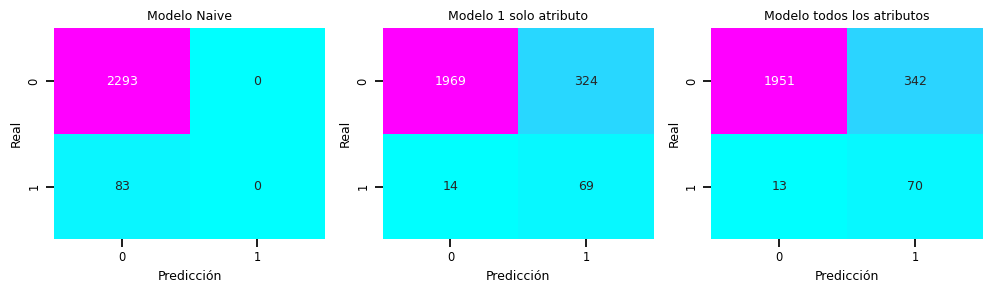

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

cms = [cm_naive, cm_1_attr, cm_3_attr]
titles = ["Modelo Naive", "Modelo 1 solo atributo", "Modelo todos los atributos"]

for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, annot=True, fmt="d", cmap="cool", cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicci√≥n")
    ax.set_ylabel("Real")

plt.tight_layout()
plt.show()

In [28]:
print(titles[0])
print(f"Sensibilidad: {sensitivity_naive}")
print(f"Especificidad: {specifity_naive}")
print(f"Exactitud balanceada: {balanced_accuracy_naive}\n")

print(titles[1])
print(f"Sensibilidad: {sensitivity_1_attr}")
print(f"Especificidad: {specifity_1_attr}")
print(f"Exactitud balanceada: {balanced_accuracy_1_attr}\n")

print(titles[2])
print(f"Sensibilidad: {sensitivity_3_attr}")
print(f"Especificidad: {specifity_3_attr}")
print(f"Exactitud balanceada: {balanced_accuracy_3_attr}")

Modelo Naive
Sensibilidad: 0.0
Especificidad: 1.0
Exactitud balanceada: 0.5

Modelo 1 solo atributo
Sensibilidad: 0.8313253012048193
Especificidad: 0.8587003924989097
Exactitud balanceada: 0.8450128468518645

Modelo todos los atributos
Sensibilidad: 0.8433734939759037
Especificidad: 0.8508504143044047
Exactitud balanceada: 0.8471119541401542


La exactitud balanceada nos muestra que, en efecto, el modelo que predice que todos van a pagar la tarjeta est√° simplemente adivinando. Por otro lado, los dos modelos son muy similares en cuanto a m√©tricas, lo que indica que agregar las columnas `student` e `income` no parece mejorar significativamente la capacidad predictiva del modelo.

#### Precisi√≥n y recuperaci√≥n (recall)

Ahora veamos otras m√©tricas √∫tiles: precisi√≥n (precision) y recuperaci√≥n (recall).

In [29]:
from sklearn.metrics import precision_score, recall_score

print(titles[0])
print(f"Precision: {precision_score(y_test, prediccion_naive, zero_division=0)}")
print(f"Recuperaci√≥n: {recall_score(y_test, prediccion_naive, zero_division=0)}\n")

print(titles[1])
print(f"Precision: {precision_score(y_test, y_pred_1_attr)}")
print(f"Recuperaci√≥n: {recall_score(y_test, y_pred_1_attr)}\n")

print(titles[2])
print(f"Precision: {precision_score(y_test_total, y_pred_3_attr)}")
print(f"Recuperaci√≥n: {recall_score(y_test_total, y_pred_3_attr)}")

Modelo Naive
Precision: 0.0
Recuperaci√≥n: 0.0

Modelo 1 solo atributo
Precision: 0.17557251908396945
Recuperaci√≥n: 0.8313253012048193

Modelo todos los atributos
Precision: 0.16990291262135923
Recuperaci√≥n: 0.8433734939759037


**Interpretaci√≥n:**

En este caso, la clase positiva (persona que no paga la tarjeta) es la m√°s importante, ya que detectar estos casos nos permite tomar acciones preventivas para reducir p√©rdidas financieras.

Por eso, nos interesa m√°s la recuperaci√≥n (recall) que la precisi√≥n (precision):

- **Recuperaci√≥n**: cu√°ntos de los que verdaderamente no pagaron fueron correctamente identificados.
- **Precisi√≥n**: cu√°ntos de los que predijimos que no pagar√≠an realmente no pagaron.

Debido al gran desbalance de clases, es com√∫n que la precisi√≥n sea baja: el modelo puede identificar algunos deudores, pero tambi√©n puede equivocarse con muchos que s√≠ iban a pagar.

> üëâ Aun as√≠, es m√°s costoso no detectar a una persona que no pagar√° (falso negativo), que predecir incorrectamente que alguien no pagar√° y s√≠ lo haga (falso positivo).

Por eso, en este problema preferimos modelos que prioricen alta recuperaci√≥n, incluso a costa de perder precisi√≥n.

#### Curva ROC

Obtengamos la curva ROC y el AUC.

In [30]:
# Nos quedamos con la clase positiva
prob_balance = log_1_attr.predict_proba(X_test)[:, -1]
prob_total = log_3_attr.predict_proba(X_test_total)[:, -1]
prob_naive = np.zeros_like(prob_total)

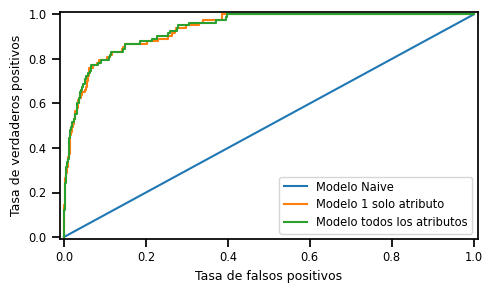

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_naive, tpr_naive, thr_naive = roc_curve(y_test, prob_naive)
fpr_balance, tpr_balance, thr_balance = roc_curve(y_test, prob_balance)
fpr_total, tpr_total, thr_total = roc_curve(y_test_total, prob_total)

plt.figure(figsize=(5, 3))
plt.plot(fpr_naive, tpr_naive, label=titles[0])
plt.plot(fpr_balance, tpr_balance, label=titles[1])
plt.plot(fpr_total, tpr_total, label=titles[2])
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend()
plt.tight_layout();

In [32]:
auc_naive = roc_auc_score(y_test, prob_naive)
auc_balance = roc_auc_score(y_test, prob_balance)
auc_total = roc_auc_score(y_test, prob_total)

print(titles[0])
print(f"AUC: {auc_naive}\n")

print(titles[1])
print(f"AUC: {auc_balance}\n")

print(titles[2])
print(f"AUC: {auc_total}")

Modelo Naive
AUC: 0.5

Modelo 1 solo atributo
AUC: 0.9344994456675371

Modelo todos los atributos
AUC: 0.936243885266316


Vemos que los modelos que entrenamos presentan un AUC bastante alto, lo cual tambi√©n se refleja en la forma de la curva ROC. Por otro lado, se confirma nuevamente que el modelo naive act√∫a como si estuviera eligiendo al azar, ya que su AUC es exactamente 0.5.

Entre los modelos entrenados, el mejor resulta ser el que utiliza solo el atributo `balance`, ya que nos brinda m√©tricas muy similares al modelo que usa los tres atributos, pero con menor complejidad. Claramente, las variables `income` y `student` no aportan tanta informaci√≥n adicional como balance.

### B√∫squeda del mejor threshold

Por √∫ltimo, vamos a analizar la curva ROC del modelo entrenado con un solo atributo. La idea es quedarnos con el valor de threshold (umbral) que est√© m√°s cerca, en t√©rminos de distancia euclidiana, del punto de **clasificaci√≥n perfecta (0, 1)**. Este punto representa el mejor equilibrio entre *Falsos Positivos* y *Verdaderos Positivos*.

> üß† **Nota**: Otra estrategia com√∫n para encontrar el mejor umbral es el √≠ndice de Youden (J), que maximiza la diferencia `tpr - fpr`, es decir, busca el punto donde la sensibilidad es mucho mayor que la tasa de falsos positivos.

In [33]:
# Distancia euclidiana al punto (0, 1)
distancias = np.sqrt((fpr_balance - 0)**2 + (tpr_balance - 1)**2)

# √çndice del threshold √≥ptimo
idx_optimo = np.argmin(distancias)

# Threshold √≥ptimo
threshold_optimo = thr_balance[idx_optimo]

print(f"üìå Threshold √≥ptimo (m√≠nima distancia a (0,1)): {threshold_optimo:.4f}")

üìå Threshold √≥ptimo (m√≠nima distancia a (0,1)): 0.4847


> ‚ö†Ô∏è **Nota**: El threshold √≥ptimo es cercano a 0.5, por lo que no esperamos mejoras dr√°sticas en las m√©tricas.

Graficamos la curva ROC y marcamos el punto √≥ptimo:

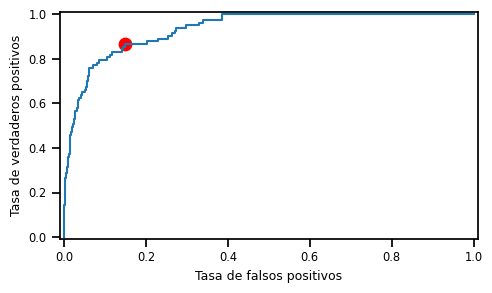

In [34]:
plt.figure(figsize=(5, 3))
plt.plot(fpr_balance, tpr_balance)
plt.scatter(fpr_balance[thr_balance==threshold_optimo], 
            tpr_balance[thr_balance==threshold_optimo], color='r', s=80)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.tight_layout();

Ahora, con ese valor, podemos calcular las nuevas predicciones:

In [35]:
y_pred_custom = (prob_balance >= threshold_optimo).astype(int)

Comparemos los resultados usando el reporte de clasificaci√≥n:

In [36]:
from sklearn.metrics import classification_report

print("Umbral no optimizado")
print(classification_report(y_test, y_pred_1_attr, digits=4))

print("Umbral optimizado")
print(classification_report(y_test, y_pred_custom, digits=4))

Umbral no optimizado
              precision    recall  f1-score   support

           0     0.9929    0.8587    0.9210      2293
           1     0.1756    0.8313    0.2899        83

    accuracy                         0.8577      2376
   macro avg     0.5843    0.8450    0.6054      2376
weighted avg     0.9644    0.8577    0.8989      2376

Umbral optimizado
              precision    recall  f1-score   support

           0     0.9944    0.8522    0.9178      2293
           1     0.1752    0.8675    0.2915        83

    accuracy                         0.8527      2376
   macro avg     0.5848    0.8598    0.6046      2376
weighted avg     0.9658    0.8527    0.8959      2376



El umbral optimizado mejora la **recuperaci√≥n (recall)**, a costa de perder un poco de **precisi√≥n**, aunque la p√©rdida es m√≠nima. El **puntaje F1** tambi√©n mejora, lo que indica que hay un mejor equilibrio entre **precisi√≥n** y **recuperaci√≥n**.

Eso s√≠, este nuevo umbral optimizado disminuye el puntaje F1 en la clase negativa, ya que ahora el modelo comete m√°s falsos positivos. Sin embargo, si nuestro inter√©s est√° principalmente en detectar correctamente a quienes no pagar√°n la tarjeta, este intercambio puede ser favorable desde una perspectiva de negocio.